In [1]:
import polars as pl
import pysentiment2 as ps
import math
import os
import re
from matplotlib_venn import venn2, venn3
import matplotlib.pyplot as plt

In [2]:
lm_dict = pl.read_csv(r'C:\Users\310\Desktop\Progects_Py\Parsim-sec\src\Analysis\Loughran-McDonald_MasterDictionary_1993-2021.csv')
hv_dict = pl.read_excel(r'C:\Users\310\Desktop\Progects_Py\Parsim-sec\src\converter_api\Harvard_inquirerbasic.xls')
hv_dict.sample(10)

Entry,Source,Positiv,Negativ,Pstv,Affil,Ngtv,Hostile,Strong,Power,Weak,Submit,Active,Passive,Pleasur,Pain,Feel,Arousal,EMOT,Virtue,Vice,Ovrst,Undrst,Academ,Doctrin,Econ@,Exch,ECON,Exprsv,Legal,Milit,Polit@,POLIT,Relig,Role,COLL,Work,…,WltTran,WltOth,WltTot,WlbGain,WlbLoss,WlbPhys,WlbPsyc,WlbPt,WlbTot,EnlGain,EnlLoss,EnlEnds,EnlPt,EnlOth,EnlTot,SklAsth,SklPt,SklOth,SklTot,TrnGain,TrnLoss,TranLw,MeansLw,EndsLw,ArenaLw,PtLw,Nation,Anomie,NegAff,PosAff,SureLw,If,NotLw,TimeSpc,FormLw,Othtags,Defined
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,null,str,str,str,str,str,str,str,str,str,str,…,str,str,str,str,str,str,str,str,str,str,str,null,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""CLATTER""","""H4""",null,"""Negativ""",null,null,null,null,null,null,null,null,null,null,null,"""Pain""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Noun""","""|"""
"""SETTLEMENT""","""H4Lvd""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""ECON""",null,null,null,"""Polit@""","""POLIT""",null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Noun""","""|"""
"""MYSTERY""","""H4Lvd""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,"""EnlOth""","""EnlTot""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Noun""","""|"""
"""STALL#2""","""H4Lvd""",null,null,null,null,null,"""Hostile""",null,null,"""Weak""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""TranLw""",null,null,null,null,null,null,null,null,null,null,null,null,null,"""SUPV""","""|"""
"""UNIFORM""","""Lvd""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Noun""",null
"""CHARACTER#1""","""H4Lvd""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Virtue""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Noun""","""| 22% noun-adj…"
"""HACK""","""H4""",null,"""Negativ""",null,null,null,null,null,null,"""Weak""",null,null,null,null,null,null,null,null,null,"""Vice""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Noun""","""|"""
"""ABSOLUTE#2""","""H4Lvd""",null,null,null,null,null,null,"""Strong""",null,null,null,null,null,null,null,null,null,null,null,null,"""Ovrst""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,n

In [3]:
#ensure that harvard dictionary entries are compatable with input strings
words = hv_dict.select(pl.col('Entry'))

hv_words = words.to_series().str.to_lowercase()

hv_words = hv_words.map_elements(lambda word: re.sub(r'#\d+', '', word))

hv_dict = hv_dict.replace_column(0, hv_words)

hv_dict = hv_dict.unique(subset="Entry", keep="last")

In [48]:
df_dict = {}

path = r'C:\Users\310\Desktop\Progects_Py\prepared_data\full_snp_five_hundred'

for company_name in os.listdir(path):
    
    file_path = os.path.join(path, company_name)
    
    match = re.search(r"\\([A-Z]+(?:\.[A-Z])?)_reports\.parquet", file_path)

    if match:
        ticker_symbol = match.group(1)
        print("Ticker Symbol:", ticker_symbol, '\n', file_path)
    else:
        print(f"Ticker symbol for {company_name} is not found")

    df_name = f"{ticker_symbol}"
    df = pl.read_parquet(file_path)

    df_dict[df_name] = df

Ticker Symbol: AAL 
 C:\Users\310\Desktop\Progects_Py\prepared_data\full_snp_five_hundred\AAL_reports.parquet
Ticker Symbol: AAPL 
 C:\Users\310\Desktop\Progects_Py\prepared_data\full_snp_five_hundred\AAPL_reports.parquet
Ticker Symbol: ABBV 
 C:\Users\310\Desktop\Progects_Py\prepared_data\full_snp_five_hundred\ABBV_reports.parquet
Ticker Symbol: ABNB 
 C:\Users\310\Desktop\Progects_Py\prepared_data\full_snp_five_hundred\ABNB_reports.parquet
Ticker Symbol: ABT 
 C:\Users\310\Desktop\Progects_Py\prepared_data\full_snp_five_hundred\ABT_reports.parquet
Ticker Symbol: ACGL 
 C:\Users\310\Desktop\Progects_Py\prepared_data\full_snp_five_hundred\ACGL_reports.parquet
Ticker Symbol: ACN 
 C:\Users\310\Desktop\Progects_Py\prepared_data\full_snp_five_hundred\ACN_reports.parquet
Ticker Symbol: ADBE 
 C:\Users\310\Desktop\Progects_Py\prepared_data\full_snp_five_hundred\ADBE_reports.parquet
Ticker Symbol: ADI 
 C:\Users\310\Desktop\Progects_Py\prepared_data\full_snp_five_hundred\ADI_reports.parquet


In [49]:
total_num_of_rep = 0

for value in df_dict.values():
    total_num_of_rep += value.width
print(total_num_of_rep)

9830


In [50]:
total_num_of_words = 0

for value in df_dict.values():
    for col in value:
        total_num_of_words += col.count()

print(total_num_of_words)

264502259


In [51]:
#average doc length
average_word_count = total_num_of_words/total_num_of_rep
print(f'Average doc length in words: {round(average_word_count)}')
ln_average_word_count = math.log(average_word_count)

Average doc length in words: 26908


In [42]:
#ENSURE CASE CoMpAtAbIlItY
positive_words_lm = lm_dict.filter(lm_dict["Positive"] > 0).to_series().str.to_lowercase()
negative_words_lm = lm_dict.filter(lm_dict["Negative"] > 0).to_series().str.to_lowercase()

print(len(positive_words_lm) + len(negative_words_lm))

positive_words_hv = hv_dict.filter(hv_dict["Positiv"] == 'Positiv').to_series().str.to_lowercase()
negative_words_hv = hv_dict.filter(hv_dict["Negativ"] == 'Negativ').to_series().str.to_lowercase()

print(len(positive_words_hv) + len(negative_words_hv))

2692
3475


In [9]:
#LM dict also contain only unique words
len(positive_words_lm) == len(set(positive_words_lm.to_list()))

True

Combine positive and negative words from LM and HVI4 dictionaries in the two sets

In [10]:
words_lm = positive_words_lm.to_frame().vstack(negative_words_lm.to_frame()).to_series().to_list()
words_hv = positive_words_hv.to_frame().vstack(negative_words_hv.to_frame()).to_series().to_list()

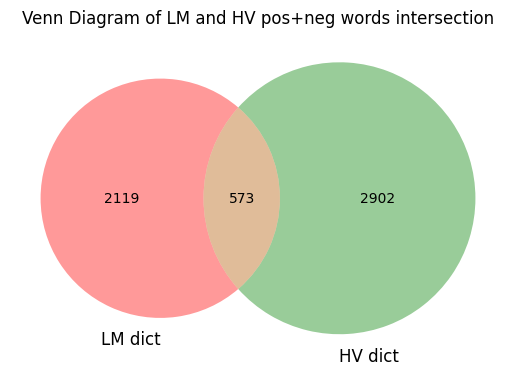

In [11]:
#here is the overlap for the whole sets
set_lm = set(words_lm)
set_hv = set(words_hv)

venn = venn2([set_lm, set_hv], set_labels=('LM dict', 'HV dict'))

plt.title('Venn Diagram of LM and HV pos+neg words intersection')
plt.show()

Clearly, there is a significant intersection between this to dictionaries. Now the goal is to construct three new dicts: Lm dict net of HV dict words, HV dict net of LM wors and the new dict out of words from intersetion.

In [52]:
#net LM dict

net_positive_lm = positive_words_lm.to_frame().join(positive_words_hv.to_frame(), left_on='Word', right_on='Entry', how='anti')
len_pos_lm1 = len(net_positive_lm)
net_positive_lm = net_positive_lm.join(negative_words_hv.to_frame(), left_on='Word', right_on='Entry', how='anti')
len_pos_lm2 = len(net_positive_lm)
print(f'Intersection between positive lm and negative hv is {len_pos_lm1 - len_pos_lm2} words')

print(f'Net_positive_lm is less then positive_words_lm on {len(positive_words_lm) - len(net_positive_lm)} words')

net_negative_lm = negative_words_lm.to_frame().join(negative_words_hv.to_frame(), left_on='Word', right_on='Entry', how='anti')
len_neg_lm1 = len(net_negative_lm)
net_negative_lm = net_negative_lm.join(positive_words_hv.to_frame(), left_on='Word', right_on='Entry', how='anti')
len_neg_lm2 = len(net_negative_lm)
print(f'Intersection between positive lm and negative hv is {len_neg_lm1 - len_neg_lm2} words')

print(f'Net_negative_lm is less then negative_words_lm on {len(negative_words_lm) - len(net_negative_lm)} words')

Intersection between positive lm and negative hv is 1 words
Net_positive_lm is less then positive_words_lm on 117 words
Intersection between positive lm and negative hv is 15 words
Net_negative_lm is less then negative_words_lm on 456 words


In [53]:
#validate separation
chec_set = set(positive_words_lm)
for word in net_positive_lm.to_series():
    if word not in chec_set:
        print('False')

chec_set = set(negative_words_lm)
for word in net_negative_lm.to_series():
    if word not in chec_set:
        print('False')

In [54]:
#net HV dict 

net_positive_hv = positive_words_hv.to_frame().join(positive_words_lm.to_frame(), left_on='Entry', right_on='Word', how='anti')
net_positive_hv = net_positive_hv.join(negative_words_lm.to_frame(), left_on='Entry', right_on='Word', how='anti')

print(f'Net_positive_hv is less then positive_words_hv on {len(positive_words_hv) - len(net_positive_hv)} words')

net_negative_hv = negative_words_hv.to_frame().join(negative_words_lm.to_frame(), left_on='Entry', right_on='Word', how='anti')
net_negative_hv = net_negative_hv.join(positive_words_lm.to_frame(), left_on='Entry', right_on='Word', how='anti')

print(f'Net_negative_hv is less then negative_words_hv on {len(negative_words_hv) - len(net_negative_hv)} words')

Net_positive_hv is less then positive_words_hv on 131 words
Net_negative_hv is less then negative_words_hv on 442 words


In [55]:
#validate separation
chec_set = set(positive_words_hv)
for word in net_positive_hv.to_series():
    if word not in chec_set:
        print('False')

chec_set = set(negative_words_hv)
for word in net_negative_hv.to_series():
    if word not in chec_set:
        print('False')

In [56]:
set_lm_pos = set(positive_words_lm)
set_lm_neg = set(negative_words_lm)
set_hv_pos = set(positive_words_hv)
set_hv_neg = set(negative_words_hv)

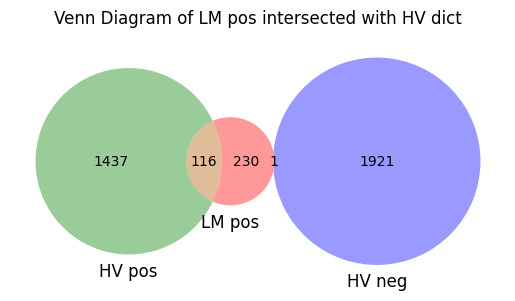

In [57]:
venn = venn3([set_lm_pos, set_hv_pos, set_hv_neg], set_labels=('LM pos', 'HV pos', 'HV neg'))

plt.title('Venn Diagram of LM pos intersected with HV dict')
plt.show()

As we can see on the graph, LM pos mostly intersected with positive part of HV dict. Acording to hypothesis, this this words from intersection are moving in the opposite direction with returns, despite, they are from positive part of dictionary. This intersection will be positive part of our intersected dictionary.

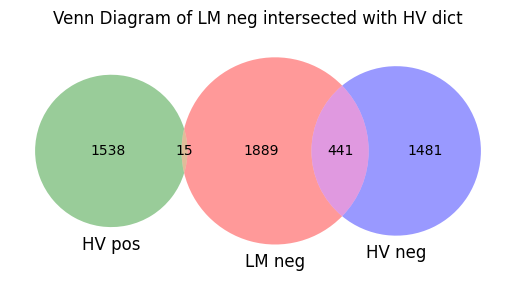

In [18]:
venn = venn3([set_lm_neg, set_hv_pos, set_hv_neg], set_labels=('LM neg', 'HV pos', 'HV neg'))

plt.title('Venn Diagram of LM neg intersected with HV dict')
plt.show()

Here we can see similar picture, intersections of cordinality 15 and 441. Now we will construct two dictcs where we will take an intersection of dictionaries and treat the sentiments of this sets in first dictioonary as in LM and in second dictionary as in HV. In both this dictionaries there will be 441 + 116 words that has same sentiment, and 15 + 1 words that are different in sentiment.


In [19]:
len(positive_words_lm), len(positive_words_hv), len(negative_words_lm), len(negative_words_hv)

(347, 1553, 2345, 1922)

Lets create this dict.

In [58]:
# Intersecton LM dict
inter_pos1 = positive_words_lm.to_frame().join(positive_words_hv.to_frame(), left_on='Word', right_on='Entry', how='semi')
print(len(inter_pos1))
inter_pos2 = positive_words_lm.to_frame().join(negative_words_hv.to_frame(), left_on='Word', right_on='Entry', how='semi')
print(len(inter_pos2))

inter_pos_lm = inter_pos1.vstack(inter_pos2)

inter_neg1 = negative_words_lm.to_frame().join(negative_words_hv.to_frame(), left_on='Word', right_on='Entry', how='semi')
print(len(inter_neg1))
inter_neg2 = negative_words_lm.to_frame().join(positive_words_hv.to_frame(), left_on='Word', right_on='Entry', how='semi')
print(len(inter_neg2))

inter_neg_lm = inter_neg1.vstack(inter_neg2)

116
1
441
15


In [59]:
positive_words_lm

Word
str
"""able"""
"""abundance"""
"""abundant"""
"""acclaimed"""
"""accomplish"""
…
"""win"""
"""winner"""
"""winners"""


In [60]:
#Intersection HV dict
inter_pos1 = positive_words_hv.to_frame().join(positive_words_lm.to_frame(), right_on='Word', left_on='Entry', how='semi')
print(len(inter_pos1))
inter_pos2 = positive_words_hv.to_frame().join(negative_words_lm.to_frame(), right_on='Word', left_on='Entry', how='semi')
print(len(inter_pos2))

inter_pos_hv = inter_pos1.vstack(inter_pos2)

inter_neg1 = negative_words_hv.to_frame().join(negative_words_lm.to_frame(), right_on='Word', left_on='Entry', how='semi')
print(len(inter_neg1))
inter_neg2 = negative_words_hv.to_frame().join(positive_words_lm.to_frame(), right_on='Word', left_on='Entry', how='semi')
print(len(inter_neg2))

inter_neg_hv = inter_neg1.vstack(inter_neg2)

116
15
441
1


In [65]:
#example series 
example_series = df_dict['USB'][df_dict['USB'].columns[4]]
example_df = df_dict['USB']
example_df
#2010-02-26

2019-02-22,2019-05-09,2019-08-01,2019-11-08,2020-02-20,2020-05-07,2020-08-06,2020-11-05,2021-02-23,2021-05-04,2021-08-03,2021-11-02,2022-02-22,2022-05-03,2022-08-04,2022-11-01,2023-02-27,2023-05-08,2023-08-07,2023-11-01
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""UNITED""","""UNITED""","""UNITED""","""UNITED""","""EXHIBIT""","""UNITED""","""UNITED""","""UNITED""","""UNITED""","""UNITED""","""UNITED""","""UNITED""","""UNITED""","""UNITED""","""UNITED""","""UNITED""","""UNITED""","""UNITED""","""UNITED""","""UNITED"""
"""STATES""","""STATES""","""STATES""","""STATES""","""The""","""STATES""","""STATES""","""STATES""","""STATES""","""STATES""","""STATES""","""STATES""","""STATES""","""STATES""","""STATES""","""STATES""","""STATES""","""STATES""","""STATES""","""STATES"""
"""SECURITIES""","""SECURITIES""","""SECURITIES""","""SECURITIES""","""following""","""SECURITIES""","""SECURITIES""","""SECURITIES""","""SECURITIES""","""SECURITIES""","""SECURITIES""","""SECURITIES""","""SECURITIES""","""SECURITIES""","""SECURITIES""","""SECURITIES""","""SECURITIES""","""SECURITIES""","""SECURITIES""","""SECURITIES"""
"""AND""","""AND""","""AND""","""AND""","""pages""","""AND""","""AND""","""AND""","""AND""","""AND""","""AND""","""AND""","""AND""","""AND""","""AND""","""AND""","""AND""","""AND""","""AND""","""AND"""
"""EXCHANGE""","""EXCHANGE""","""EXCHANGE""","""EXCHANGE""","""discuss""","""EXCHANGE""","""EXCHANGE""","""EXCHANGE""","""EXCHANGE""","""EXCHANGE""","""EXCHANGE""","""EXCHANGE""","""EXCHANGE""","""EXCHANGE""","""EXCHANGE""","""EXCHANGE""","""EXCHANGE""","""EXCHANGE""","""EXCHANGE""","""EXCHANGE"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
null,null,null,null,"""Polaris""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
null,null,null,null,"""Industries""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
null,null,null,null,"""Inc""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null


In [62]:
example_series.filter(example_series != "N/A")


2020-02-20
str
"""EXHIBIT"""
"""The"""
"""following"""
"""pages"""
"""discuss"""
…
"""Polaris"""
"""Industries"""
"""Inc"""


This func counts positive and negative appearences in doc (series) for each (out of six) dictionaries. After that it calculates polarity score for this serires out of each dict.


In [63]:
def count_scores_in_doc(series):

        fails = {}
        
        #grouped series that became a df, where each row is unique word and its count in document 
        num_of_w = series.value_counts().rename({"count": "count in doc"})

        #first col of this df (only words by itself)
        only_w = num_of_w[num_of_w.columns[0]]

        #count the words from LM dictionary and so it's polarity score
        pos_lm = num_of_w.filter(only_w.is_in(positive_words_lm)).select(pl.col("count in doc")).sum().item()
        neg_lm = num_of_w.filter(only_w.is_in(negative_words_lm)).select(pl.col("count in doc")).sum().item()
        
        lm_polarity_score = (pos_lm - neg_lm) / (pos_lm + neg_lm)

        #count the words from LM dictionary and so it's polarity score
        pos_hv = num_of_w.filter(only_w.is_in(positive_words_hv)).select(pl.col("count in doc")).sum().item()
        neg_hv = num_of_w.filter(only_w.is_in(negative_words_hv)).select(pl.col("count in doc")).sum().item()

        hv_polarity_score = (pos_hv - neg_hv) / (pos_hv + neg_hv)

        #count the words from net LM dictionary and so it's polarity score
        pos_net_lm = num_of_w.filter(only_w.is_in(net_positive_lm)).select(pl.col("count in doc")).sum().item()
        neg_net_lm = num_of_w.filter(only_w.is_in(net_negative_lm)).select(pl.col("count in doc")).sum().item()

        if pos_net_lm + neg_net_lm > 0:
                lm_net_polarity_score = (pos_net_lm - neg_net_lm) / (pos_net_lm + neg_net_lm)
        else: 
                fails["net_lm_fail"] = 1
                lm_net_polarity_score = 0

        #count the words from net HV dictionary and so it's polarity score
        pos_net_hv = num_of_w.filter(only_w.is_in(net_positive_hv)).select(pl.col("count in doc")).sum().item()
        neg_net_hv = num_of_w.filter(only_w.is_in(net_negative_hv)).select(pl.col("count in doc")).sum().item()
        
        if pos_net_hv + neg_net_hv > 0:
                hv_net_polarity_score = (pos_net_hv - neg_net_hv) / (pos_net_hv + neg_net_hv)
        else:   
                fails["net_hv_fail"] = 1
                hv_net_polarity_score = 0

        #count the words from intersection LM dictionary and so their polarity score
        pos_inter_lm = num_of_w.filter(only_w.is_in(inter_pos_lm)).select(pl.col("count in doc")).sum().item()
        neg_inter_lm = num_of_w.filter(only_w.is_in(inter_neg_lm)).select(pl.col("count in doc")).sum().item()

        if pos_inter_lm + neg_inter_lm > 0:
                inter_polarity_score_lm = (pos_inter_lm - neg_inter_lm) / (pos_inter_lm + neg_inter_lm)
        else:
                fails["inter_fail"] = 1
                inter_polarity_score_lm = 0

        #count the words from intersection HV dictionary and so their polarity score
        pos_inter_hv = num_of_w.filter(only_w.is_in(inter_pos_hv)).select(pl.col("count in doc")).sum().item()
        neg_inter_hv = num_of_w.filter(only_w.is_in(inter_neg_hv)).select(pl.col("count in doc")).sum().item()
        if pos_inter_hv + neg_inter_hv > 0:
                inter_polarity_score_hv = (pos_inter_hv - neg_inter_hv) / (pos_inter_hv + neg_inter_hv)
        else: 
                inter_polarity_score_hv = 0

        
        return [lm_polarity_score, hv_polarity_score, lm_net_polarity_score, hv_net_polarity_score, inter_polarity_score_lm, inter_polarity_score_hv], fails

count_scores_in_doc(example_series)


([-0.7382683410442828,
  0.5209187858900738,
  -0.7860082304526749,
  0.7233632862644416,
  -0.6524953789279113,
  -0.6451016635859519],
 {})

This func extracts the doc len from the title of the series.

In [64]:
len_pattern = r"_(\d+)$"
date_pattern = r"\d{4}-\d{2}-\d{2}"

def get_len_and_date(series):
    
    match_len = re.search(len_pattern, series.name)
    doc_len = match_len.group(1)

    match_date = re.search(date_pattern, series.name)
    date = match_date.group(0)

    return int(doc_len), date
    
get_len_and_date(example_series)


AttributeError: 'NoneType' object has no attribute 'group'

In [27]:
counter = 0
total_fails = {}

for company_name, df in df_dict.items():

    score_dict = {}

    for col in df:
        score_lst, fails = count_scores_in_doc(col)
        doc_len, date = get_len_and_date(col)

        score_lst.append(doc_len)
        
        score_dict[date] = score_lst
        if fails:
            for fail in fails:
                total_fails[fail] = total_fails.get(fail, 0) + fails[fail]
    
    df = pl.DataFrame(score_dict)
    counter += 1
    
    print(f'Iteration for {company_name} is done successfully; \n {len(df_dict) - counter} remaining')

    # Determine the output directory and file name
    output_dir = os.path.join('data', '2013_reports')
    os.makedirs(output_dir, exist_ok=True)

    file_name_new = f"{company_name}.parquet"
    full_path = os.path.join(output_dir, file_name_new)
    full_path = os.path.normpath(full_path)

    # Write the DataFrame to Parquet
    df.write_parquet(full_path)

    print(f"{full_path} created successfully")
print(total_fails)

Iteration for AAPL is done successfully; 
 443 remaining
data\2013_reports\AAPL.parquet created successfully
Iteration for ABBV is done successfully; 
 442 remaining
data\2013_reports\ABBV.parquet created successfully
Iteration for ABT is done successfully; 
 441 remaining
data\2013_reports\ABT.parquet created successfully
Iteration for ACGL is done successfully; 
 440 remaining
data\2013_reports\ACGL.parquet created successfully
Iteration for ACN is done successfully; 
 439 remaining
data\2013_reports\ACN.parquet created successfully
Iteration for ADBE is done successfully; 
 438 remaining
data\2013_reports\ADBE.parquet created successfully
Iteration for ADI is done successfully; 
 437 remaining
data\2013_reports\ADI.parquet created successfully
Iteration for ADM is done successfully; 
 436 remaining
data\2013_reports\ADM.parquet created successfully
Iteration for ADP is done successfully; 
 435 remaining
data\2013_reports\ADP.parquet created successfully
Iteration for ADSK is done su

KeyboardInterrupt: 

jupyter nbconvert --to html Parsim-sec\src\Analysis\intersetion_scores.ipynb